# Preprocessing Data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import numpy as np

from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from wordcloud import WordCloud

import re


# Loaded CSV files data
calls_df = pd.read_csv('calls.csv')
customers_df = pd.read_csv('customers.csv')
reason_df = pd.read_csv('reason.csv')
sentiment_df = pd.read_csv('sentiment_statistics.csv')

# Checking the first 5 rows of each dataset
print("Calls Dataset:")
print(calls_df.info(), "\n")

print("Customers Dataset:")
print(customers_df.info(), "\n")

print("Reason Dataset:")
print(reason_df.info(), "\n")

print("Sentiment Statistics Dataset:")
print(sentiment_df.info(), "\n")


Calls Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71810 entries, 0 to 71809
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   call_id                  71810 non-null  int64 
 1   customer_id              71810 non-null  int64 
 2   agent_id                 71810 non-null  int64 
 3   call_start_datetime      71810 non-null  object
 4   agent_assigned_datetime  71810 non-null  object
 5   call_end_datetime        71810 non-null  object
 6   call_transcript          71810 non-null  object
dtypes: int64(3), object(4)
memory usage: 3.8+ MB
None 

Customers Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71810 entries, 0 to 71809
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customer_id       71810 non-null  int64  
 1   customer_name     71810 non-null  object 
 2   elite_level_code  46043

In [2]:
# Convert columns to datetime in Calls Dataset
calls_df['call_start_datetime'] = pd.to_datetime(calls_df['call_start_datetime'], format='%m/%d/%Y %H:%M')
calls_df['agent_assigned_datetime'] = pd.to_datetime(calls_df['agent_assigned_datetime'], format='%m/%d/%Y %H:%M')
calls_df['call_end_datetime'] = pd.to_datetime(calls_df['call_end_datetime'], format='%m/%d/%Y %H:%M')


In [3]:
# Derived call duration and wait time in seconds
calls_df['call_duration'] = (calls_df['call_end_datetime'] - calls_df['call_start_datetime']).dt.total_seconds()
calls_df['wait_time'] = (calls_df['agent_assigned_datetime'] - calls_df['call_start_datetime']).dt.total_seconds()

# statistics for derived columns
print("Call Duration Summary:")
print(calls_df['call_duration'].describe(), "\n")

print("Wait Time Summary:")
print(calls_df['wait_time'].describe(), "\n")


Call Duration Summary:
count    71810.000000
mean      1134.116140
std        784.781415
min        180.000000
25%        660.000000
50%        900.000000
75%       1320.000000
max       7740.000000
Name: call_duration, dtype: float64 

Wait Time Summary:
count    71810.000000
mean       437.067539
std        151.129771
min        180.000000
25%        300.000000
50%        420.000000
75%        540.000000
max        900.000000
Name: wait_time, dtype: float64 



In [4]:
# Merge Calls and Reason Dataset on call_id
calls_reason_df = pd.merge(calls_df, reason_df, on='call_id', how='left')

# Merge with Sentiment Statistics Dataset on call_id
calls_reason_sentiment_df = pd.merge(calls_reason_df, sentiment_df, on='call_id', how='left')

# Merge with Customers Dataset on customer_id
final_df = pd.merge(calls_reason_sentiment_df, customers_df, on='customer_id', how='left')

# maintaing consistency in final dataset by droping redundant column
final_df.drop('agent_id_y', axis=1, inplace=True)

# Rename agent_id_x to agent_id
final_df.rename(columns={'agent_id_x': 'agent_id'}, inplace=True)

In [5]:
# Filling missing values in `elite_level_code` with mode (most common value)
final_df['elite_level_code']= final_df['elite_level_code'].fillna(0)
final_df['primary_call_reason']= final_df['primary_call_reason'].fillna('')
final_df['agent_tone']= final_df['agent_tone'].fillna(final_df['agent_tone'].mode()[0])
final_df['average_sentiment']= final_df['average_sentiment'].fillna(final_df['average_sentiment'].mode()[0])

# missing values in Customers Dataset
print("Missing Values in Customers Dataset:")
print(final_df.isnull().sum(), "\n")

Missing Values in Customers Dataset:
call_id                    0
customer_id                0
agent_id                   0
call_start_datetime        0
agent_assigned_datetime    0
call_end_datetime          0
call_transcript            0
call_duration              0
wait_time                  0
primary_call_reason        0
agent_tone                 0
customer_tone              0
average_sentiment          0
silence_percent_average    0
customer_name              0
elite_level_code           0
dtype: int64 



In [6]:
# Converting to categories as required
final_df['agent_tone'] = final_df['agent_tone'].astype('category').cat.codes
final_df['customer_tone'] = final_df['customer_tone'].astype('category').cat.codes
final_df['customer_name'] = final_df['customer_name'].astype('string')
final_df['primary_call_reason'] = final_df['primary_call_reason'].astype('string')
final_df['call_transcript'] = final_df['call_transcript'].astype('string')


In [7]:

# Clean the 'primary_call_reason' column
final_df['primary_call_reason'] = final_df['primary_call_reason'].str.strip()

def clean_data(text):
    cleaned_text = re.sub(r'\s+', ' ', text)
    cleaned_text = cleaned_text.replace('-', ' ')
    cleaned_text = cleaned_text.replace('&', 'and')

    return cleaned_text

final_df['primary_call_reason'] = final_df['primary_call_reason'].apply(clean_data)

final_df['primary_call_reason'] = final_df['primary_call_reason'].astype('string')

# Predicting Missing Call Reasons

In [8]:
# Preprocessed the call transcripts
vectorizer = TfidfVectorizer(stop_words='english', max_features=1000)
X = vectorizer.fit_transform(final_df['call_transcript'])

# Used KMeans clustering to find patterns in the transcripts
kmeans = KMeans(n_clusters=5, random_state=42)
final_df['cluster'] = kmeans.fit_predict(X)

# Check the top terms in each cluster (these will help identify self-solvable issues)
terms = vectorizer.get_feature_names_out()
order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]

print("Top terms per cluster:")
for i in range(5):
    print(f"Cluster {i}:")
    for ind in order_centroids[i, :10]:
        print(terms[ind])

Top terms per cluster:
Cluster 0:
flight
change
agent
customer
fee
let
date
help
work
need
Cluster 1:
customer
delay
agent
flight
voucher
refund
let
delays
missed
delayed
Cluster 2:
flight
agent
customer
let
wanted
check
time
seat
help
just
Cluster 3:
experience
customer
bag
flight
agent
refund
voucher
took
issues
united
Cluster 4:
flight
agent
customer
let
tomorrow
sir
meeting
like
delay
united


cluster                   0     1     2    3     4
primary_call_reason                               
                       2457   550   778  286  1086
Baggage                1453   271   380  127   601
Booking                1340   269   371  118   539
Check In                923   212   294  109   366
Checkout                907   198   266  112   405
Communications         1918   393   558  218   753
Digital Support         561   139   216   58   251
Disability              171    53    69   20    90
ETC                     432   104   152   63   201
IRROPS                 6511  1583  1688  835  2694
Mileage Plus           2892   541   917  350  1151
Other Topics            378    66   148   54   172
Post Flight            1991   438   635  248  1018
Products and Services  1524   340   502  175   791
Schedule Change         336    89   119   37   150
Seating                3030   672  1021  370  1272
Traveler Updates        445    95   158   51   188
Unaccompanied Minor      43    

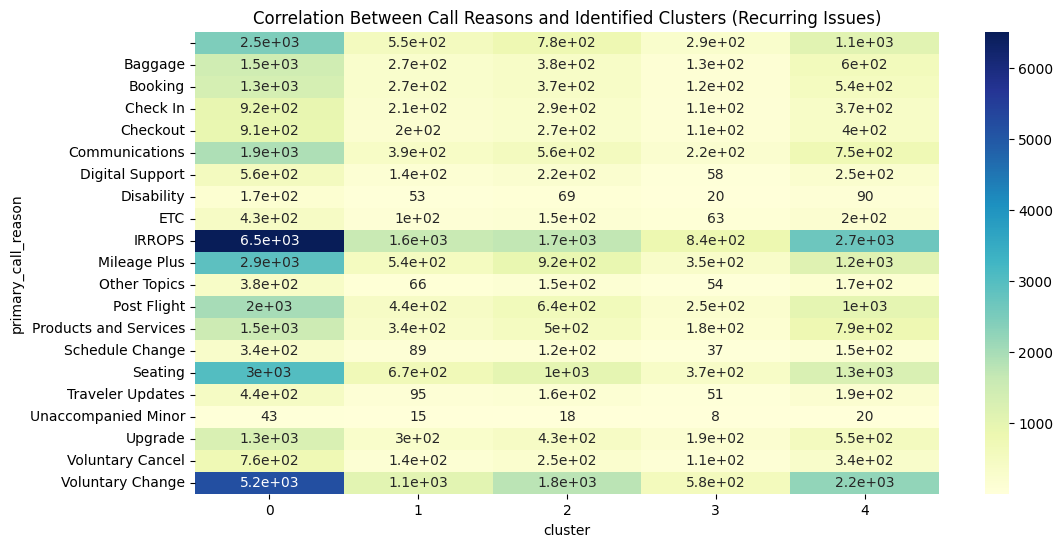

In [9]:
# Group by primary call reason and cluster to see patterns
reason_cluster_analysis = final_df.groupby(['primary_call_reason', 'cluster']).size().unstack(fill_value=0)
print(reason_cluster_analysis)

# Visualized the recurring issues that correlate with call reasons
plt.figure(figsize=(12, 6))
sns.heatmap(reason_cluster_analysis, cmap="YlGnBu", annot=True)
plt.title('Correlation Between Call Reasons and Identified Clusters (Recurring Issues)')
plt.show()

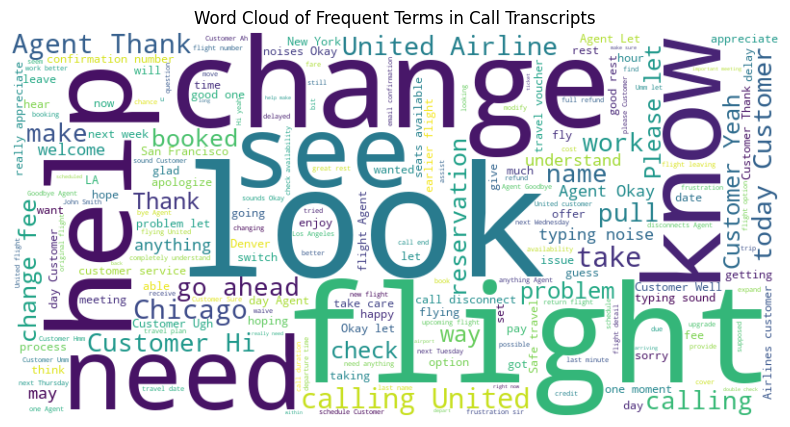

In [10]:
# Generated a word cloud from the transcripts
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(final_df['call_transcript']))
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Frequent Terms in Call Transcripts')
plt.show()

In [11]:
# Split known data into training (with primary_call_reason) and test set (where primary_call_reason is empty)
train_df = final_df[final_df['primary_call_reason'] != '']
test_df = final_df[final_df['primary_call_reason'] == '']

# Feature extraction: Extracting text and other features
X_train = train_df['call_transcript']
y_train = train_df['primary_call_reason']
X_test = test_df['call_transcript']

# Using TF-IDF for text feature extraction and Random Forest for classification
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=5000)),
    ('clf', RandomForestClassifier(n_estimators=100, random_state=42))
])

# Train the model
pipeline.fit(X_train, y_train)

# Predict on test data
test_df['primary_call_reason'] = pipeline.predict(X_test)

# Saving the results in the required format
test_df[['call_id', 'primary_call_reason']].to_csv('test_vaibhavgupta.csv', index=False)


C:\Users\HP\AppData\Local\Temp\ipykernel_9960\2995918093.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['primary_call_reason'] = pipeline.predict(X_test)


In [12]:
final_df = final_df.merge(test_df, on='call_id', how='left', suffixes=('', '_predicted'))

# Fill the missing values in primary_call_reason with the predicted values
final_df['primary_call_reason'] = final_df.apply(
    lambda row: row['primary_call_reason_predicted'] if row['primary_call_reason'] == '' else row['primary_call_reason'],
    axis=1
)
final_df = final_df.drop(columns=['primary_call_reason_predicted'])

In [13]:
# Save final_df as a CSV file
final_df.to_csv('calls_data.csv', index=False)

# Check the structure of the final merged DataFrame
print(final_df.info())
print(final_df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71810 entries, 0 to 71809
Data columns (total 32 columns):
 #   Column                             Non-Null Count  Dtype         
---  ------                             --------------  -----         
 0   call_id                            71810 non-null  int64         
 1   customer_id                        71810 non-null  int64         
 2   agent_id                           71810 non-null  int64         
 3   call_start_datetime                71810 non-null  datetime64[ns]
 4   agent_assigned_datetime            71810 non-null  datetime64[ns]
 5   call_end_datetime                  71810 non-null  datetime64[ns]
 6   call_transcript                    71810 non-null  string        
 7   call_duration                      71810 non-null  float64       
 8   wait_time                          71810 non-null  float64       
 9   primary_call_reason                71810 non-null  object        
 10  agent_tone                        

Percentage difference between the average handling time for the most frequent and least frequent call reasons:  -5.268234743114375


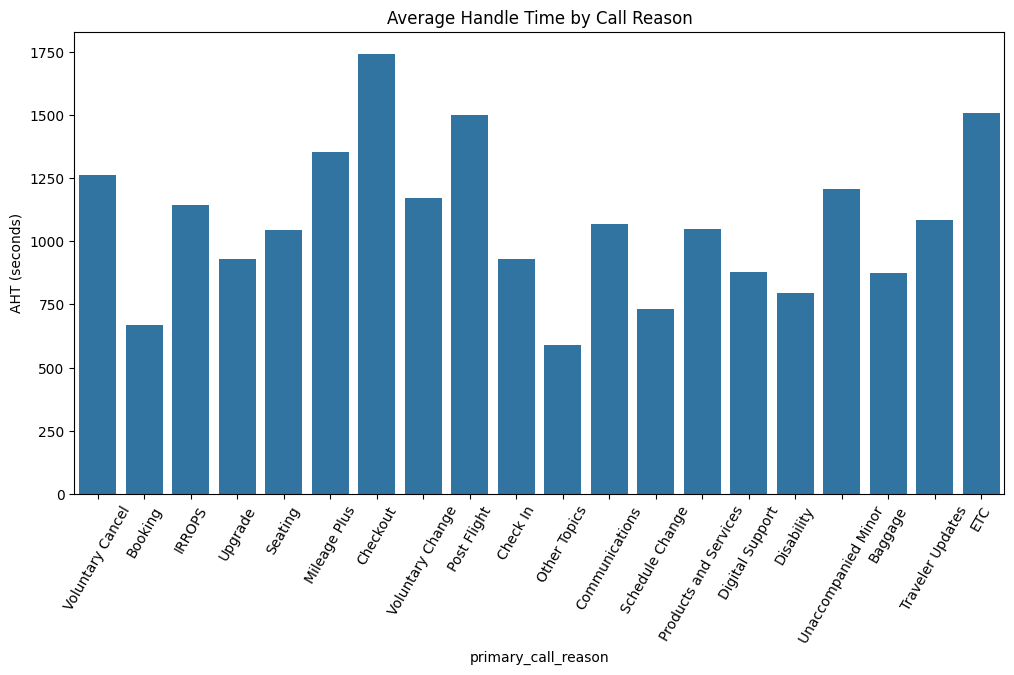

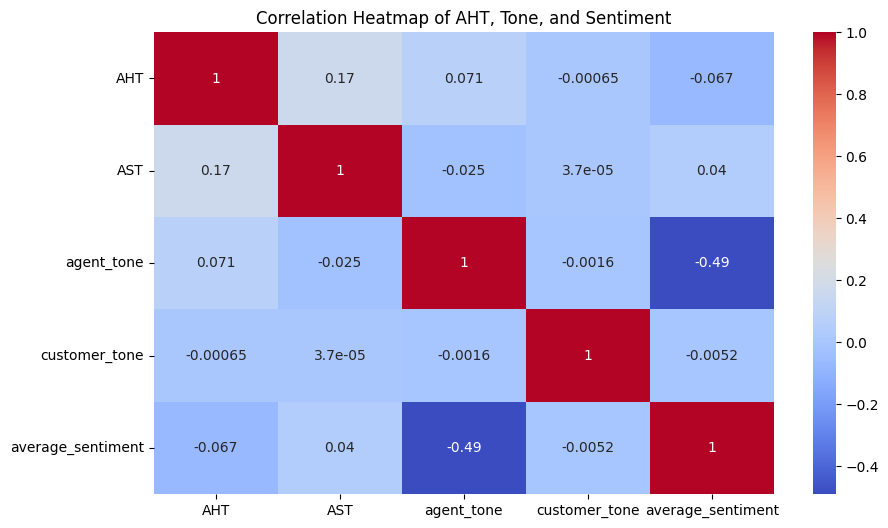

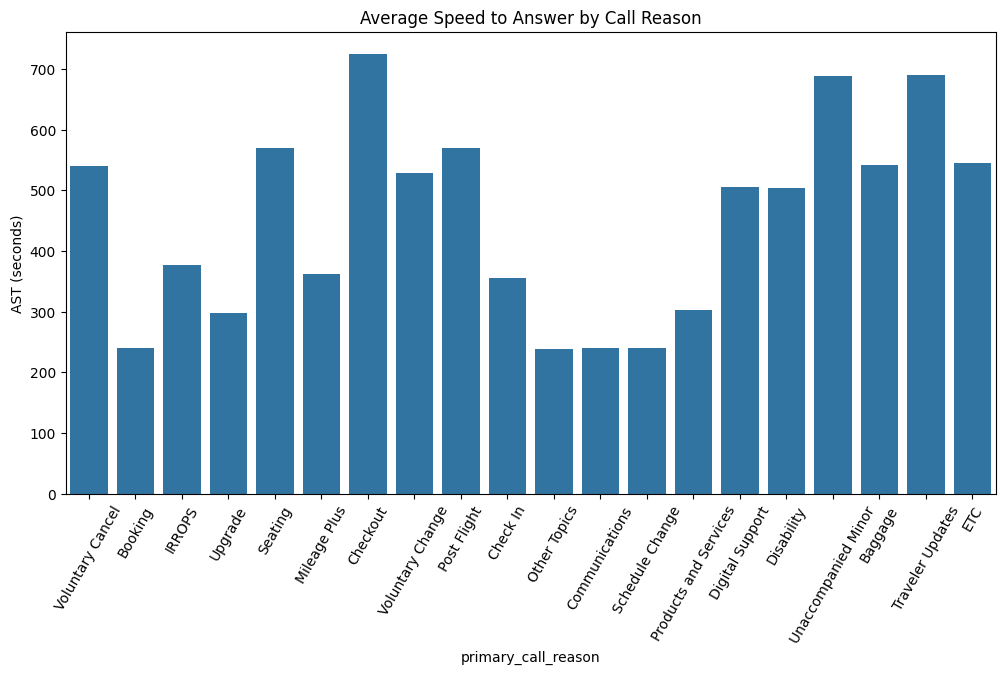

In [14]:
# Calculate AHT (Average Handle Time) and AST (Average Speed to Answer)
final_df['AHT'] = final_df['call_duration']
final_df['AST'] = final_df['wait_time']

# Group by 'primary_call_reason' to get the most and least frequent reasons
call_reason_counts = final_df['primary_call_reason'].value_counts()
most_frequent_reason = call_reason_counts.idxmax()
least_frequent_reason = call_reason_counts.idxmin()

# Calculate average AHT for the most and least frequent call reasons
most_frequent_aht = final_df[final_df['primary_call_reason'] == most_frequent_reason]['AHT'].mean()
least_frequent_aht = final_df[final_df['primary_call_reason'] == least_frequent_reason]['AHT'].mean()

# Calculate percentage difference in AHT
percentage_diff_aht = ((most_frequent_aht - least_frequent_aht) / least_frequent_aht) * 100

print("Percentage difference between the average handling time for the most frequent and least frequent call reasons: ", percentage_diff_aht)

# Visualize AHT and AST over different call reasons
plt.figure(figsize=(12, 6))
sns.barplot(x='primary_call_reason', y='AHT', data=final_df, estimator='mean', errorbar=None)
plt.xticks(rotation=60)
plt.title('Average Handle Time by Call Reason')
plt.ylabel('AHT (seconds)')
plt.show()

# Visualize the correlation between agent/customer tone and AHT
plt.figure(figsize=(10, 6))
sns.heatmap(final_df[['AHT', 'AST', 'agent_tone', 'customer_tone', 'average_sentiment']].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap of AHT, Tone, and Sentiment')
plt.show()

# Visualize AST (Average Speed to Answer) for different call reasons
plt.figure(figsize=(12, 6))
sns.barplot(x='primary_call_reason', y='AST', data=final_df, estimator='mean', errorbar=None)
plt.xticks(rotation=60)
plt.title('Average Speed to Answer by Call Reason')
plt.ylabel('AST (seconds)')
plt.show()

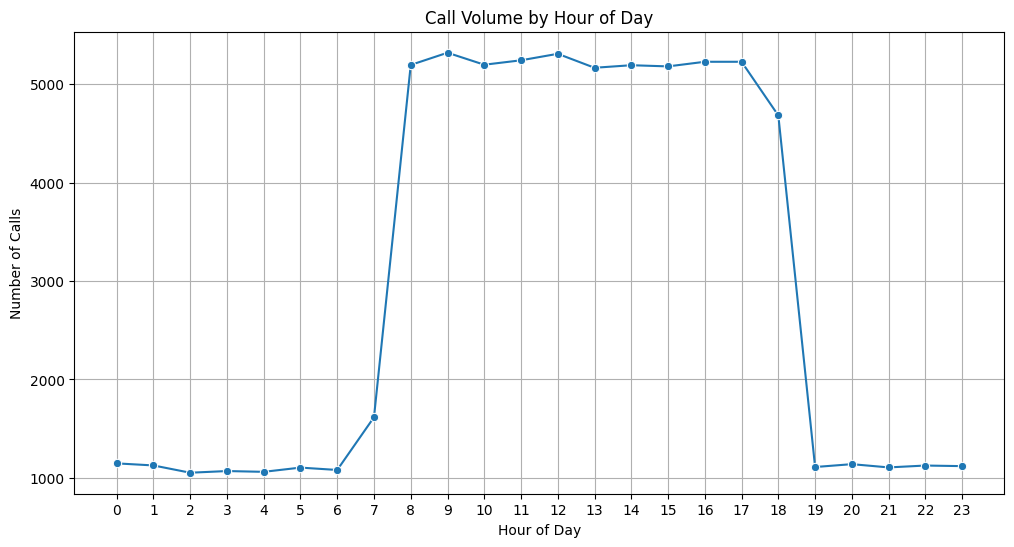

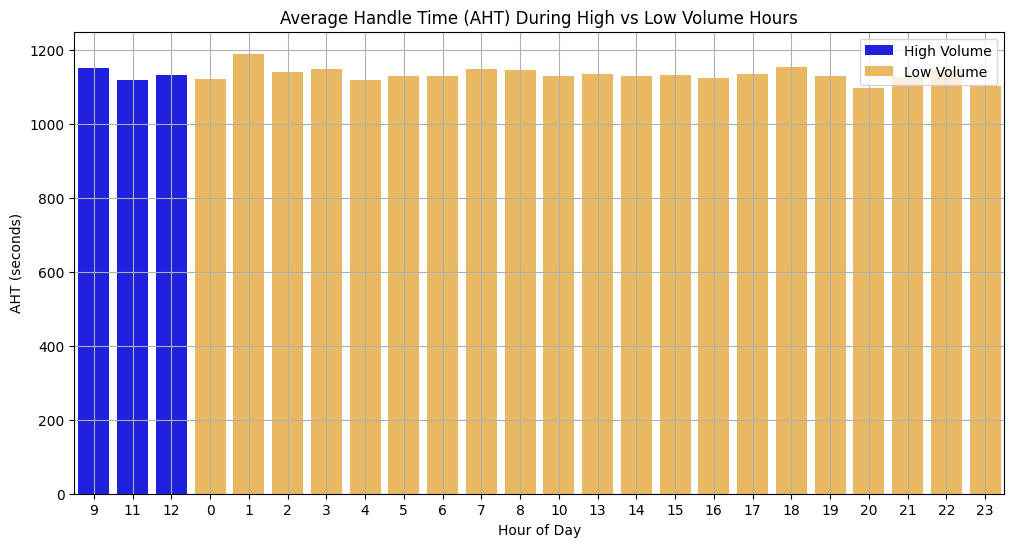

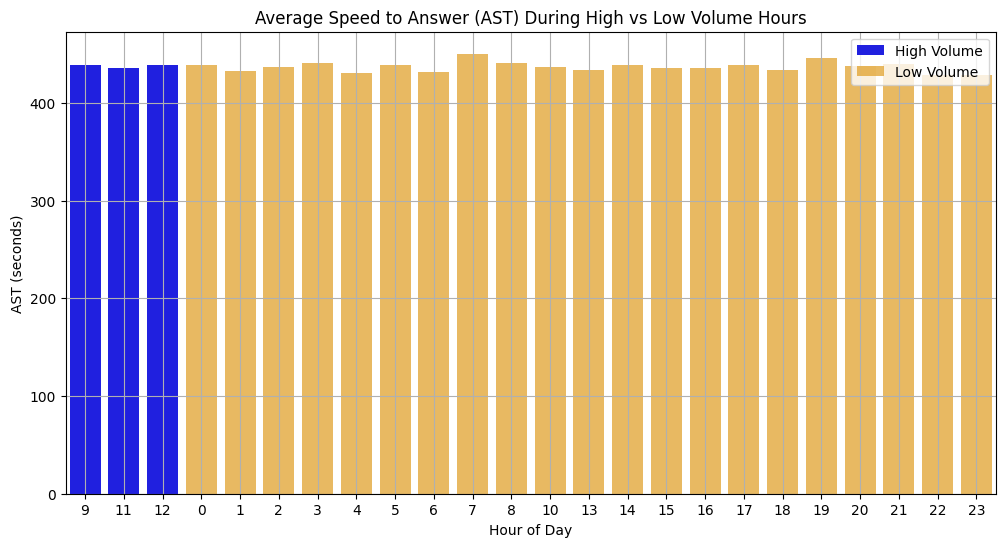

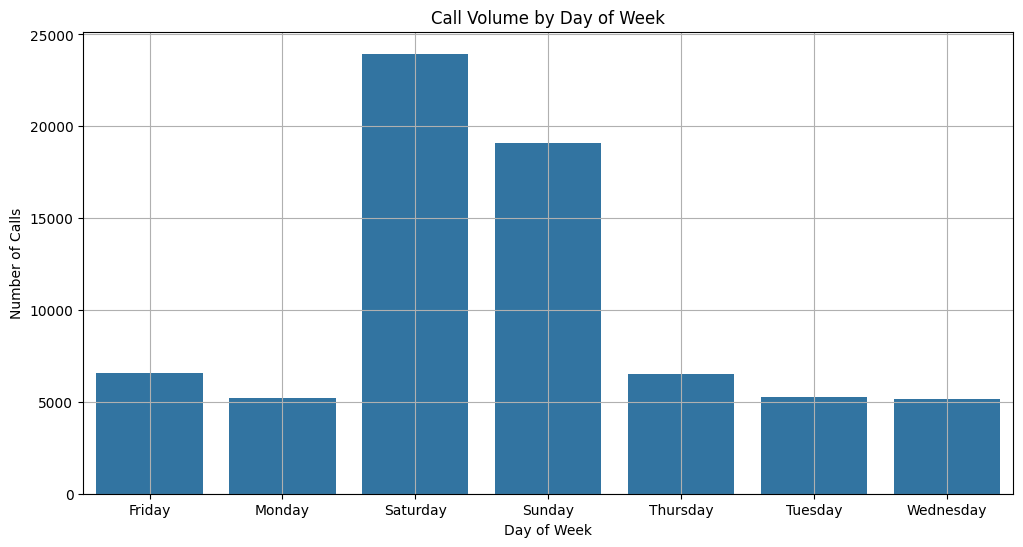

In [15]:
# Extract hour of day and day of week to analyze call volumes
final_df['call_hour'] = final_df['call_start_datetime'].dt.hour
final_df['call_day'] = final_df['call_start_datetime'].dt.day_name()

# Group by hour and calculate the number of calls, AHT, and AST for each hour
hourly_analysis = final_df.groupby('call_hour').agg({
    'call_id': 'count',
    'AHT': 'mean',
    'AST': 'mean'
}).reset_index()

# Identify high-volume periods (e.g., top 20% of hours with highest call volumes)
high_volume_threshold = hourly_analysis['call_id'].quantile(0.90)
high_volume_hours = hourly_analysis[hourly_analysis['call_id'] >= high_volume_threshold]
low_volume_hours = hourly_analysis[hourly_analysis['call_id'] < high_volume_threshold]

# Visualize the distribution of call volumes over the day
plt.figure(figsize=(12, 6))
sns.lineplot(x='call_hour', y='call_id', data=hourly_analysis, marker='o')
plt.title('Call Volume by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Calls')
plt.xticks(range(24))
plt.grid(True)
plt.show()

# Compare AHT and AST during high-volume and low-volume hours
plt.figure(figsize=(12, 6))
sns.barplot(x='call_hour', y='AHT', data=high_volume_hours, color='blue', label='High Volume')
sns.barplot(x='call_hour', y='AHT', data=low_volume_hours, color='orange', label='Low Volume', alpha=0.7)
plt.title('Average Handle Time (AHT) During High vs Low Volume Hours')
plt.xlabel('Hour of Day')
plt.ylabel('AHT (seconds)')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 6))
sns.barplot(x='call_hour', y='AST', data=high_volume_hours, color='blue', label='High Volume')
sns.barplot(x='call_hour', y='AST', data=low_volume_hours, color='orange', label='Low Volume', alpha=0.7)
plt.title('Average Speed to Answer (AST) During High vs Low Volume Hours')
plt.xlabel('Hour of Day')
plt.ylabel('AST (seconds)')
plt.legend()
plt.grid(True)
plt.show()

# Analyze by day of the week as well
daily_analysis = final_df.groupby('call_day').agg({
    'call_id': 'count',
    'AHT': 'mean',
    'AST': 'mean'
}).reset_index()

plt.figure(figsize=(12, 6))
sns.barplot(x='call_day', y='call_id', data=daily_analysis)
plt.title('Call Volume by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Number of Calls')
plt.grid(True)
plt.show()

# Calculating the percentage of calls that could have been self-solved

In [16]:
vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
X = vectorizer.fit_transform(final_df['call_transcript'])

# Applying LDA (Latent Dirichlet Allocation) to find common topics
lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda.fit(X)

# Printing the top terms per topic to manually inspect
terms = vectorizer.get_feature_names_out()
for idx, topic in enumerate(lda.components_):
    print(f"Topic {idx}:")
    print([terms[i] for i in topic.argsort()[-10:]])  # Show top 10 terms per topic

# List of keywords associated with self-solvable calls from topics
self_solvable_keywords = ['cancel', 'seating', 'booking', 'upgrade', 'voucher', 'delay', 'refund', 'flight status', 'seat']

# Flag calls based on the presence of self-solvable keywords in the transcript
final_df['is_self_solvable'] = np.where(
    (final_df['primary_call_reason'].str.contains('|'.join(self_solvable_keywords), case=False, na=False)) |
    (final_df['call_transcript'].str.contains('|'.join(self_solvable_keywords), case=False, na=False)) |
    (final_df['call_duration'] < 300) |  # Calls with a duration under 5 minutes
    ((final_df['agent_tone'] == 0) & (final_df['customer_tone'] == 0)),  # Neutral sentiment (tone close to 0)
    1, 0  # 1 indicates the call could be self-solved
)

# Calculate the percentage of self-solvable calls
self_solvable_percentage = (final_df['is_self_solvable'].sum() / final_df.shape[0]) * 100
print(f"Percentage of calls that could be solved via IVR: {self_solvable_percentage:.2f}%")


Topic 0:
['check', 'aisle', 'economy', 'wanted', 'flight', 'upgrade', 'customer', 'agent', 'bag', 'seat']
Topic 1:
['wanted', 'just', 'delays', 'let', 'time', 'forecast', 'weather', 'customer', 'agent', 'flight']
Topic 2:
['need', 'work', 'help', 'date', 'let', 'fee', 'customer', 'agent', 'change', 'flight']
Topic 3:
['really', 'la', 'like', 'earlier', 'meeting', 'tomorrow', 'let', 'customer', 'agent', 'flight']
Topic 4:
['delays', 'experience', 'let', 'sir', 'refund', 'voucher', 'delay', 'flight', 'agent', 'customer']
Percentage of calls that could be solved via IVR: 92.63%


# Ploting Call Volume before and after IVR

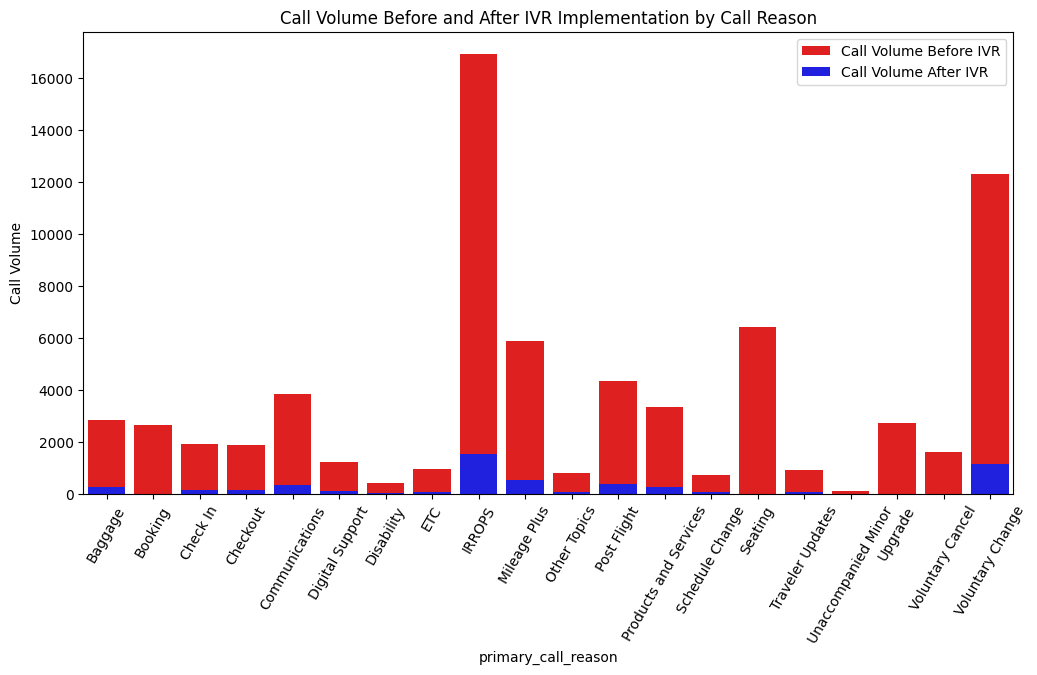

In [17]:
# Calculate current AHT, AST, and Call Volume for each call reason (before IVR)
grouped_before = final_df.groupby('primary_call_reason').agg(
    aht_before=('call_duration', 'mean'),
    ast_before=('wait_time', 'mean'),
    call_volume_before=('call_id', 'count')
).reset_index()

# Separate self-solvable calls (handled by IVR) and agent-handled calls
self_solvable = final_df[final_df['is_self_solvable'] == 1]
agent_handled = final_df[final_df['is_self_solvable'] == 0]

# Calculate AHT, AST, and Call Volume for self-solvable calls (IVR handled)
grouped_ivr = self_solvable.groupby('primary_call_reason').agg(
    ivr_handled_volume=('call_id', 'count')
).reset_index()

# Calculate AHT, AST, and Call Volume for agent-handled calls (post IVR implementation)
grouped_after = agent_handled.groupby('primary_call_reason').agg(
    aht_after=('call_duration', 'mean'),
    ast_after=('wait_time', 'mean'),
    call_volume_after=('call_id', 'count')
).reset_index()

# Merged before and after datasets
merged_data = pd.merge(grouped_before, grouped_after, on='primary_call_reason', how='left')
merged_data = pd.merge(merged_data, grouped_ivr, on='primary_call_reason', how='left')

# Fill missing values for ivr_handled_volume with 0
merged_data['ivr_handled_volume'] = merged_data['ivr_handled_volume'].fillna(0)


# Plot Call Volume before and after IVR
plt.figure(figsize=(12, 6))
sns.barplot(x='primary_call_reason', y='call_volume_before', data=merged_data, color='red', label='Call Volume Before IVR')
sns.barplot(x='primary_call_reason', y='call_volume_after', data=merged_data, color='blue', label='Call Volume After IVR')
plt.title('Call Volume Before and After IVR Implementation by Call Reason')
plt.xticks(rotation=60)
plt.ylabel('Call Volume')
plt.legend()
plt.show()


# Plotting distributions for key metrics to get insights from data

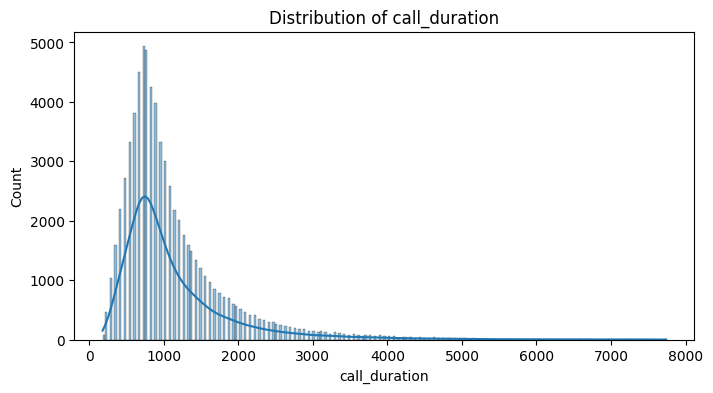

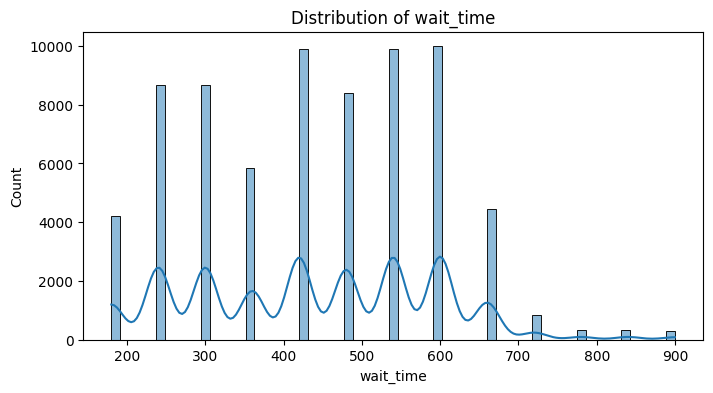

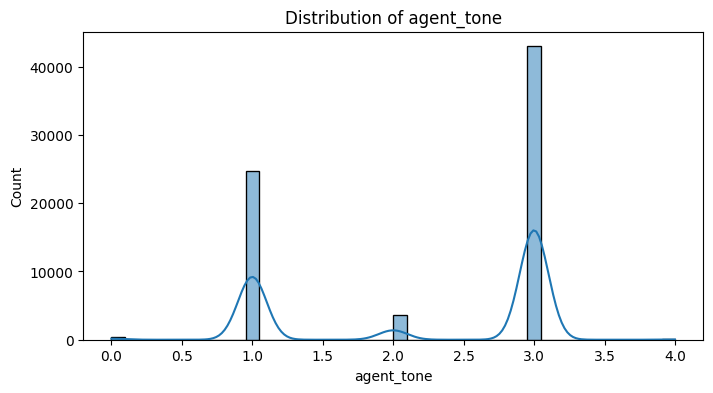

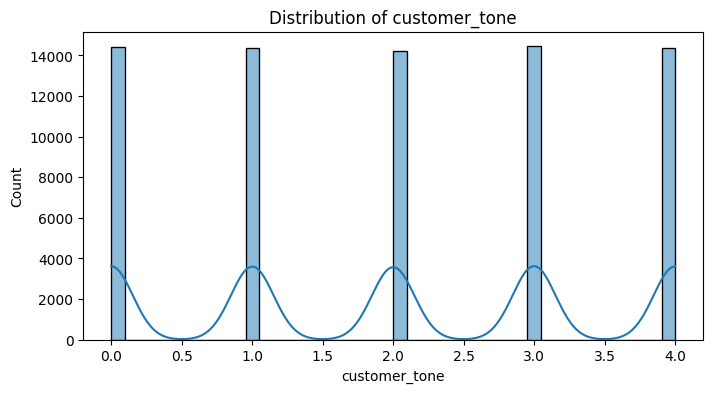

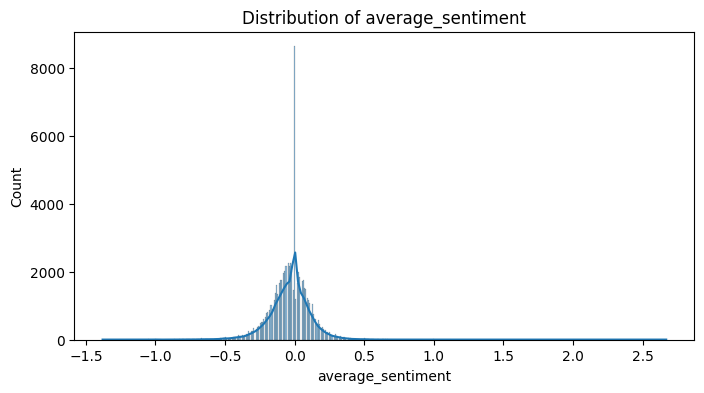

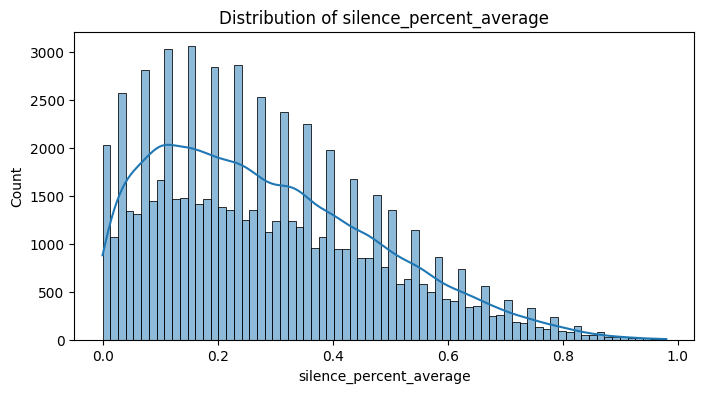

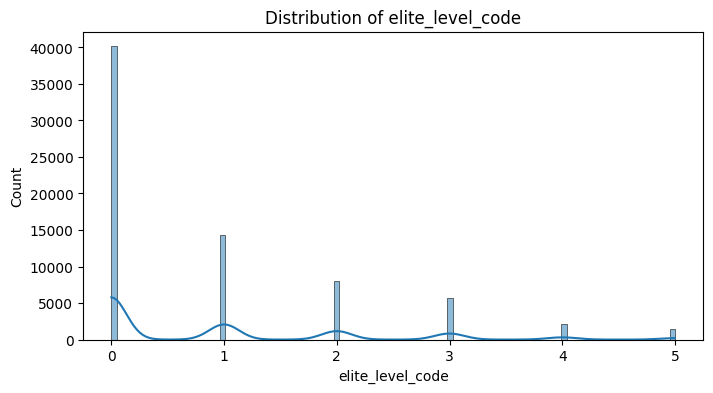

In [18]:
numeric_columns = ['call_duration', 'wait_time', 'agent_tone', 'customer_tone', 
                   'average_sentiment', 'silence_percent_average', 'elite_level_code']

# Plotting distributions for key metrics
for col in numeric_columns:
    plt.figure(figsize=(8, 4))
    sns.histplot(final_df[col], kde=True)
    plt.title(f'Distribution of {col}')
    plt.show()


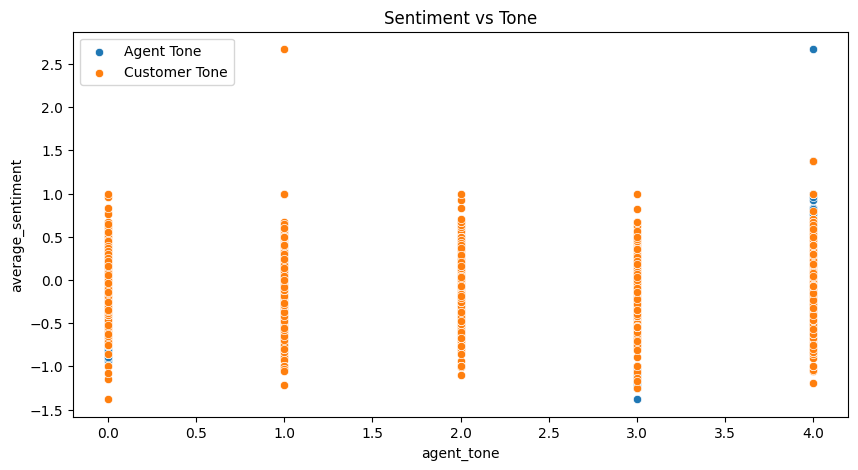

In [19]:
# Scatter plot of sentiment vs agent and customer tones
plt.figure(figsize=(10,5))
sns.scatterplot(x='agent_tone', y='average_sentiment', data=final_df, label='Agent Tone')
sns.scatterplot(x='customer_tone', y='average_sentiment', data=final_df, label='Customer Tone')
plt.title('Sentiment vs Tone')
plt.legend()
plt.show()


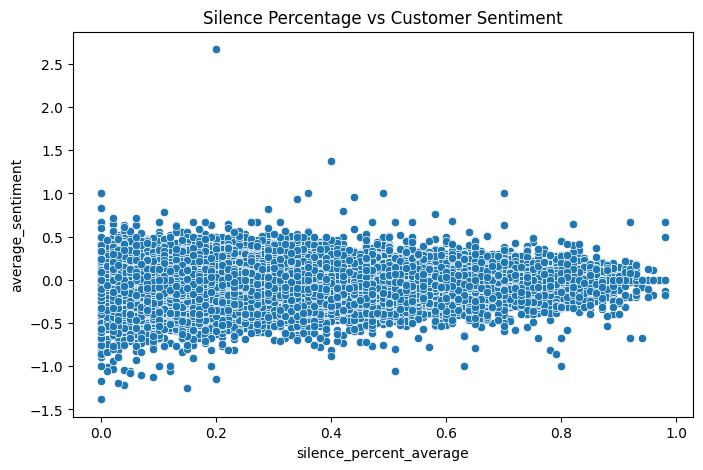

In [20]:
# Scatter plot of silence percentage vs sentiment
plt.figure(figsize=(8, 5))
sns.scatterplot(x='silence_percent_average', y='average_sentiment', data=final_df)
plt.title('Silence Percentage vs Customer Sentiment')
plt.show()


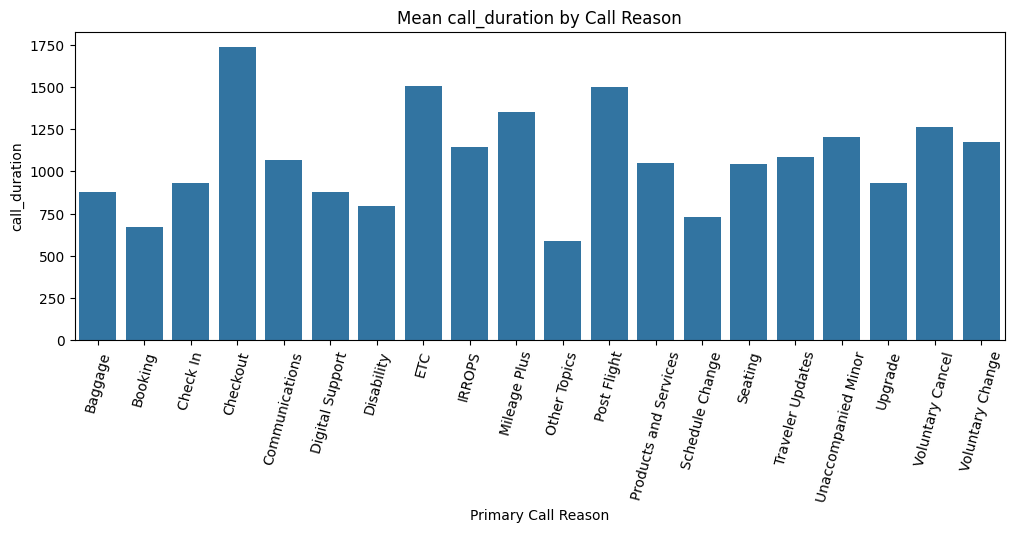

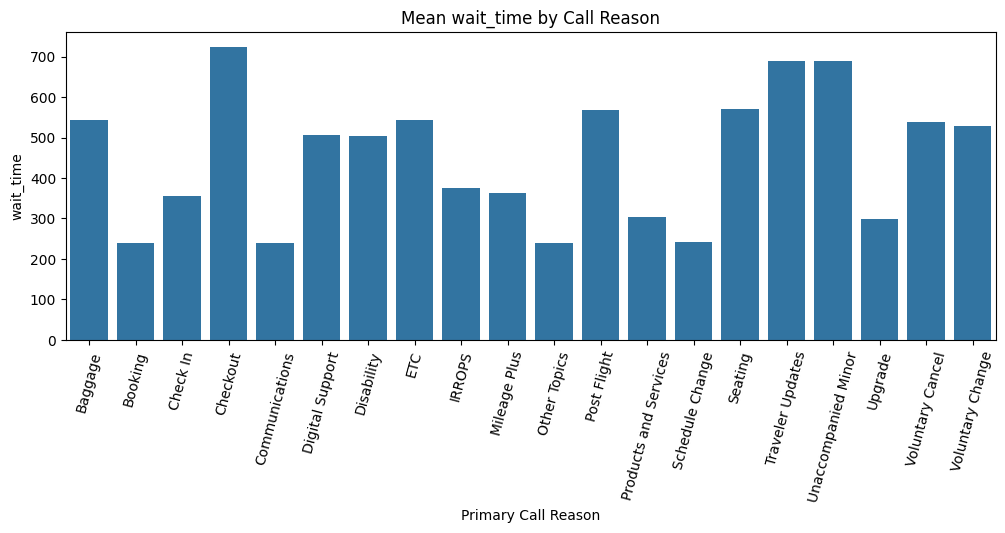

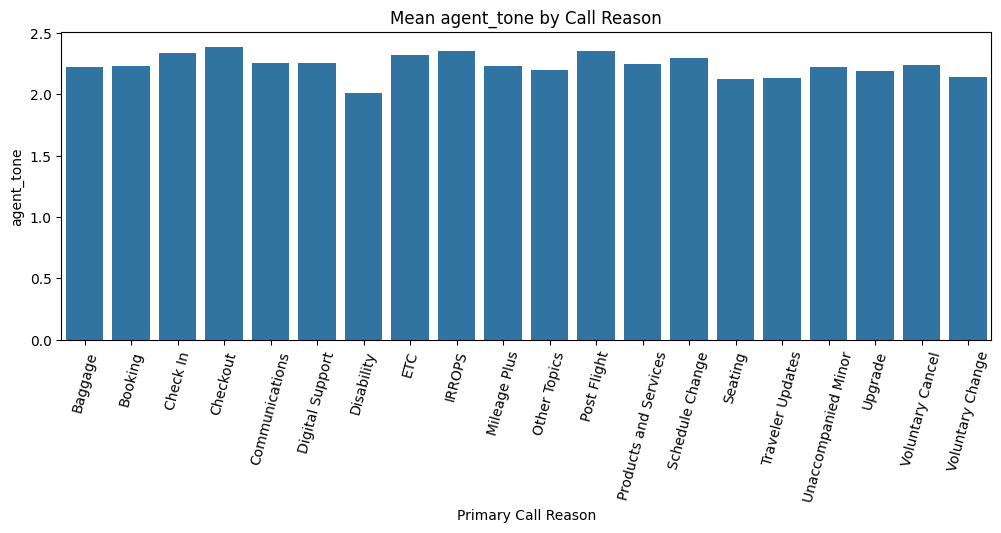

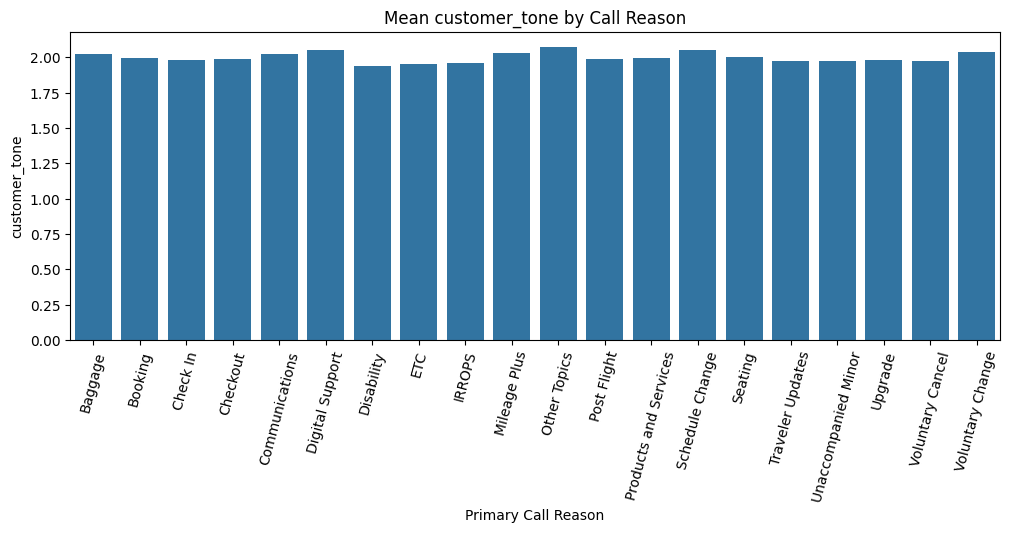

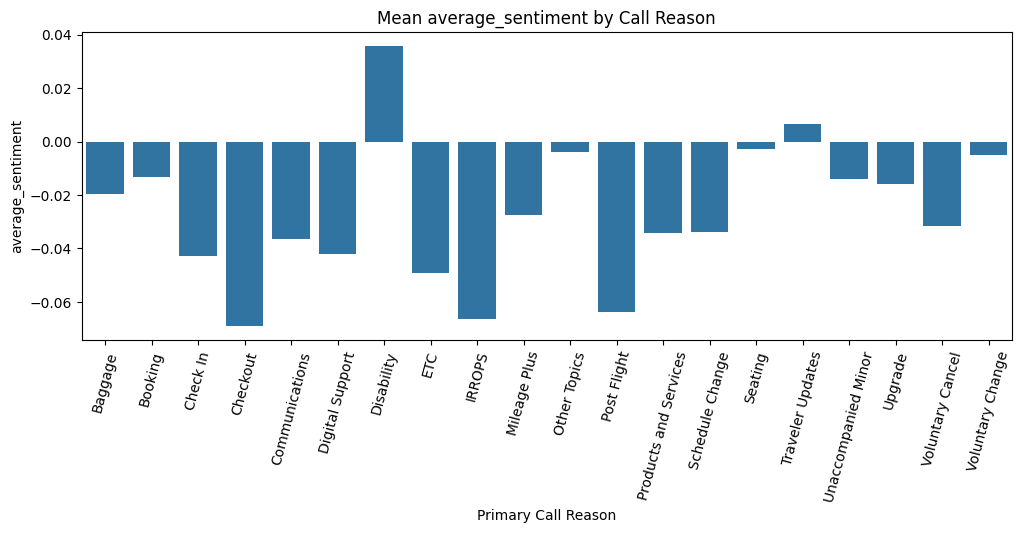

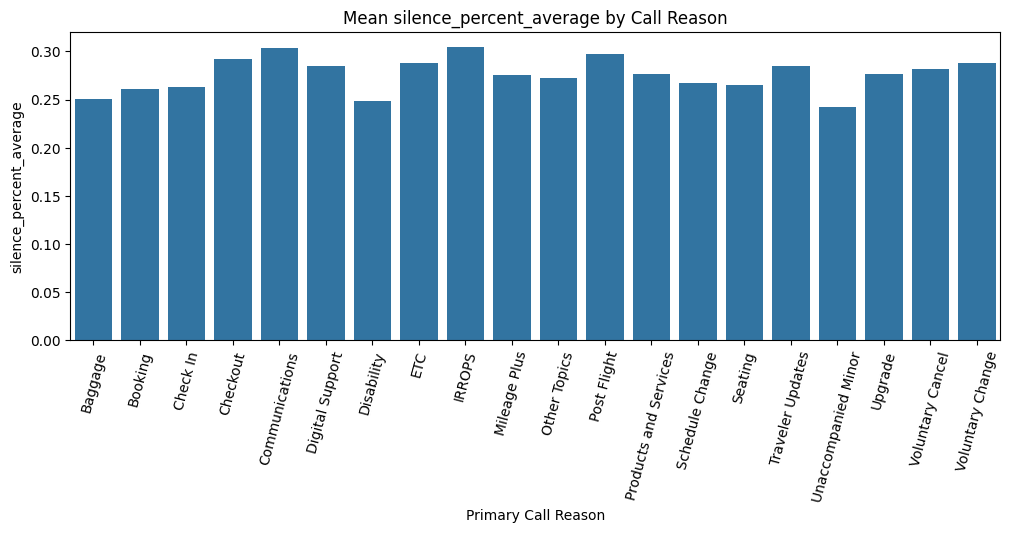

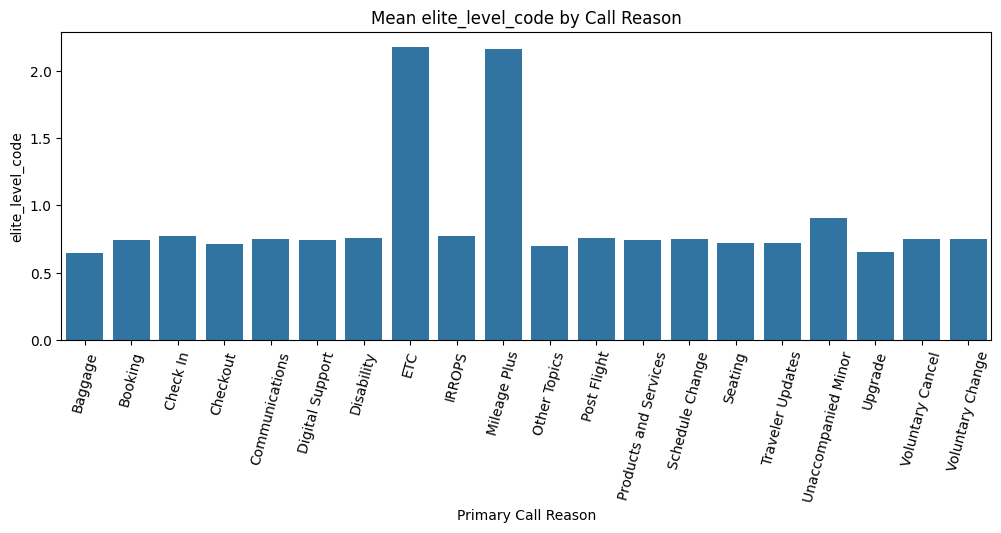

In [21]:
mean_metrics = final_df.groupby('primary_call_reason')[numeric_columns].mean().reset_index()

# Creating subplots for each metric
for i, metric in enumerate(numeric_columns, 1):
    plt.figure(figsize=(12, 4))
    # sns.histplot(mean_metrics, kde=True)
    sns.barplot(data=mean_metrics, x='primary_call_reason', y=metric)
    plt.title(f'Mean {metric} by Call Reason')
    plt.xticks(rotation=75)
    plt.ylabel(metric)
    plt.xlabel('Primary Call Reason')
    plt.show()